In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import csv
import json
import sklearn
from google.cloud import bigquery as bq
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.options.mode.chained_assignment = None
%matplotlib inline

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error

In [3]:
query="""
    SELECT
      *
    FROM
      `ual3d-277909.nl.zuid_holland_ml_df`
"""

df = bq.Client().query(query).to_dataframe()
df = df.sample(frac=0.1)
df.head()

,osm_way_id,bldg_height,area,perimeter,length,building_levels,city,country,postcode,year,count_vertices,compactness,complexity,count_neighbor,state_name
548056,286013813,2.42,31.668519,24.167790,9.742269,NaN,None,NL,None,1965.0,8,0.825433,10.187791,514.0,South Holland
257616,267740503,11.47,155.517230,54.253729,18.623922,NaN,None,NL,None,1930.0,10,0.814825,15.363316,24.0,South Holland
915702,269238132,9.09,53.454361,31.884644,11.823649,NaN,None,NL,None,1980.0,7,0.812858,11.791954,622.0,South Holland
606805,289342342,3.13,19.947939,18.831572,7.014432,NaN,None,NL,None,1967.0,6,0.840751,8.910705,1291.0,South Holland
836536,254955823,6.00,55.546692,37.396677,13.394829,NaN,None,NL,None,1976.0,9,0.706482,13.698356,890.0,South Holland


In [4]:
df.set_index('osm_way_id', inplace=True)

In [5]:
df.shape

(163867, 14)

In [6]:
df.dtypes

bldg_height        float64
area               float64
perimeter          float64
length             float64
building_levels    float64
city                object
country             object
postcode            object
year               float64
count_vertices       int64
compactness        float64
complexity         float64
count_neighbor     float64
state_name          object
dtype: object

In [7]:

df["city"] = df["city"].astype("category")
df["state_name"] = df["state_name"].astype("category")
df["country"] = df["country"].astype("category")
df["postcode"] = df["postcode"].astype("category")
# df["year"] = df["year"].astype(float).astype("Int64")
# df["count_vertices"] = df["count_vertices"].astype(float).astype("Int64")
# df["count_neighbor"] = df["count_neighbor"].astype(float).astype("Int64")
# df["building_levels"] = df["building_levels"].astype(float).astype("Int64")
df.dtypes

bldg_height         float64
area                float64
perimeter           float64
length              float64
building_levels     float64
city               category
country            category
postcode           category
year                float64
count_vertices        int64
compactness         float64
complexity          float64
count_neighbor      float64
state_name         category
dtype: object

In [8]:
label_col = ["bldg_height"]
num_cols = ["area", "perimeter", "length", "building_levels", "year", "count_vertices", "compactness", "complexity", "count_neighbor"]
# cat_cols = ["city", "postcode"]
cat_cols = [col for col in df.columns if col not in (num_cols + label_col)]


In [9]:
print('count unique city:', len(pd.unique(df['city'])))
print('unique city:', pd.unique(df['city']))

print('\ncount unique postcode:', len(pd.unique(df['postcode'])))
print('unique postcode:', pd.unique(df['postcode']))

print('\ncount unique year:', len(pd.unique(df['year'])))
print('unique year:', pd.unique(df['year']))

count unique city: 37
unique city: [NaN, Pijnacker, Voorburg, 's-Gravenhage, Rijswijk, ..., 's-Gravendeel, Alphen aan den Rijn, Ouddorp, Warmond, Mookhoek]
Length: 37
Categories (36, object): [Pijnacker, Voorburg, 's-Gravenhage, Rijswijk, ..., Alphen aan den Rijn, Ouddorp, Warmond, Mookhoek]

count unique postcode: 77
unique postcode: [NaN, 2641ZA, 2272AP, 2273AV, 2585BJ, ..., 2333CH, 3271AH, 2525NL, 2513AM, 2511VC]
Length: 77
Categories (76, object): [2641ZA, 2272AP, 2273AV, 2585BJ, ..., 3271AH, 2525NL, 2513AM, 2511VC]

count unique year: 382
unique year: [1965. 1930. 1980. 1967. 1976. 1932. 1950. 1987. 2003. 2019. 1951. 1984.
 1978. 1991. 1982. 1908. 2002. 1968. 1986. 1938. 2006. 1958. 1981. 2005.
 1920. 1874. 2018. 1993. 1889. 1997. 1964. 1957. 1972. 1988. 1995. 1960.
 1900. 1919. 1940. 1926. 1949. 1913. 1910. 1963. 1925. 1928. 1941. 1937.
 1969. 2010. 1970. 1800. 1948. 1974. 1998. 1911. 1931. 1961. 2004. 1966.
 1975. 1945. 1917. 1955. 2016. 1971. 2008. 1985. 1983. 1979. 1860. 1934.

In [10]:
df.isna().sum()

bldg_height             0
area                    0
perimeter               0
length                  0
building_levels    161537
city               163780
country                 0
postcode           163790
year                   13
count_vertices          0
compactness             0
complexity              0
count_neighbor         29
state_name              0
dtype: int64

In [11]:

num_df = df[num_cols]

In [12]:
num_df.describe()

,area,perimeter,length,building_levels,year,count_vertices,compactness,complexity,count_neighbor
count,163867.000000,163867.000000,163867.000000,2330.000000,163854.000000,163867.000000,163867.000000,163867.000000,163838.000000
mean,129.216545,34.406317,12.482241,1.521459,1969.952879,7.289332,0.820333,11.499628,627.372673
std,1332.750250,43.736159,15.094950,1.579363,37.106089,5.151727,0.070051,5.159791,308.249104
min,0.009402,0.388354,0.140021,-3.000000,1310.000000,4.000000,0.270673,1.247153,1.000000
25%,11.069789,13.823555,5.052223,1.000000,1957.000000,5.000000,0.791849,7.570885,430.000000
50%,50.053991,29.757954,10.850732,1.000000,1976.000000,5.000000,0.843915,11.133280,640.000000
75%,71.386777,38.869056,14.321122,1.750000,1993.000000,8.000000,0.872023,13.328806,833.000000
max,256205.513826,3925.805649,965.213901,27.000000,2020.000000,394.000000,0.999942,174.494474,2125.000000


[]

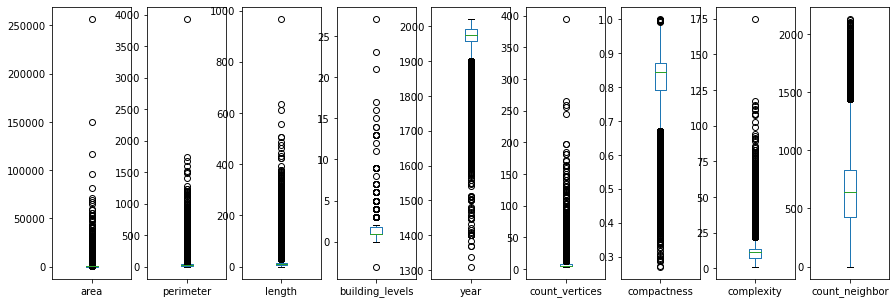

In [13]:
num_df.plot(kind='box', subplots=True, figsize=(15,5))
plt.plot()

In [16]:
num_df['count_neighbor'].fillna(0, inplace=True)

In [17]:
num_df.describe()

,area,perimeter,length,building_levels,year,count_vertices,compactness,complexity,count_neighbor
count,163867.000000,163867.000000,163867.000000,2330.000000,163854.000000,163867.000000,163867.000000,163867.000000,163867.000000
mean,129.216545,34.406317,12.482241,1.521459,1969.952879,7.289332,0.820333,11.499628,627.261645
std,1332.750250,43.736159,15.094950,1.579363,37.106089,5.151727,0.070051,5.159791,308.334783
min,0.009402,0.388354,0.140021,-3.000000,1310.000000,4.000000,0.270673,1.247153,0.000000
25%,11.069789,13.823555,5.052223,1.000000,1957.000000,5.000000,0.791849,7.570885,430.000000
50%,50.053991,29.757954,10.850732,1.000000,1976.000000,5.000000,0.843915,11.133280,640.000000
75%,71.386777,38.869056,14.321122,1.750000,1993.000000,8.000000,0.872023,13.328806,833.000000
max,256205.513826,3925.805649,965.213901,27.000000,2020.000000,394.000000,0.999942,174.494474,2125.000000


[]

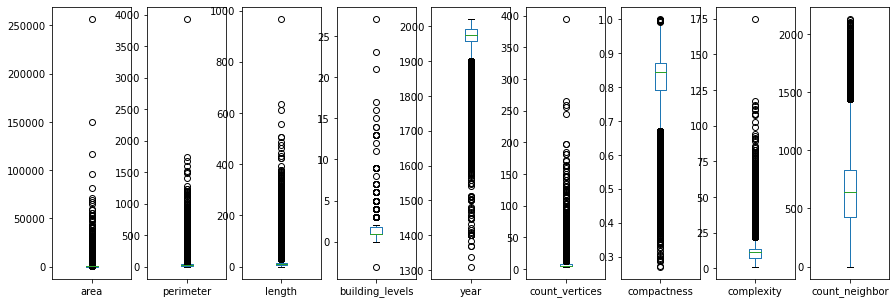

In [18]:
num_df.plot(kind='box', subplots=True, figsize=(15,5))
plt.plot()

We assume that count_neighbor is 0 when null. 

In [19]:
df['count_neighbor'].fillna(0, inplace=True)
df.isna().sum()

bldg_height             0
area                    0
perimeter               0
length                  0
building_levels    161537
city               163780
country                 0
postcode           163790
year                   13
count_vertices          0
compactness             0
complexity              0
count_neighbor          0
state_name              0
dtype: int64

In [20]:
df.columns

Index(['bldg_height', 'area', 'perimeter', 'length', 'building_levels', 'city',
       'country', 'postcode', 'year', 'count_vertices', 'compactness',
       'complexity', 'count_neighbor', 'state_name'],
      dtype='object')

In [21]:
# drop country and state_name as they are irrelevant 
df = df.drop(['country', 'state_name'], axis=1)
print(df.columns)

Index(['bldg_height', 'area', 'perimeter', 'length', 'building_levels', 'city',
       'postcode', 'year', 'count_vertices', 'compactness', 'complexity',
       'count_neighbor'],
      dtype='object')


In [23]:
# drop length and perimeter as they are highly correlated 
df = df.drop(['length', 'perimeter'], axis=1)
print(df.columns)

Index(['bldg_height', 'area', 'building_levels', 'city', 'postcode', 'year',
       'count_vertices', 'compactness', 'complexity', 'count_neighbor'],
      dtype='object')


In [25]:
num_cols = ['area', 'building_levels', 'year', 'count_vertices', 'compactness', 'complexity', 'count_neighbor']
print(num_cols)

['area', 'building_levels', 'year', 'count_vertices', 'compactness', 'complexity', 'count_neighbor']


In [26]:
cat_cols = [col for col in df.columns if col not in (num_cols + label_col)]
print(cat_cols)


['city', 'postcode']


In [27]:
X = df.drop('bldg_height', axis=1)
y = df['bldg_height']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

In [28]:
X, y

(                  area  building_levels city postcode    year  count_vertices  \
 osm_way_id                                                                      
 286013813    31.668519              NaN  NaN      NaN  1965.0               8   
 267740503   155.517230              NaN  NaN      NaN  1930.0              10   
 269238132    53.454361              NaN  NaN      NaN  1980.0               7   
 289342342    19.947939              NaN  NaN      NaN  1967.0               6   
 254955823    55.546692              NaN  NaN      NaN  1976.0               9   
 ...                ...              ...  ...      ...     ...             ...   
 281447074    40.180768              NaN  NaN      NaN  1910.0               7   
 291474383    20.881269              NaN  NaN      NaN  1956.0               6   
 289377741     9.795538              NaN  NaN      NaN  1939.0               6   
 269387946    15.053732              NaN  NaN      NaN  1917.0               6   
 253643931    12

In [31]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean', add_indicator=True)),
    ('scaler', StandardScaler()),
    ('kbest', SelectKBest(f_regression, k='all'))])


In [33]:
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', add_indicator=True, fill_value="NA")),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore')),
    ('kbest', SelectKBest(f_regression, k='all'))])

In [34]:
preprocessor = ColumnTransformer(transformers=[
        ('num_transformer', num_transformer, num_cols),
        ('cat_transfomer', cat_transformer, cat_cols)])

In [35]:
# ('imputer', KNNImputer(n_neighbors=50, weights='uniform'))
# ,('kbest', SelectKBest(f_regression, k=5))
# ,('kbest', SelectKBest(f_regression, k=50))

In [36]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

In [37]:
# print(sorted(sklearn.metrics.SCORERS.keys()) )

In [38]:
regressors = []
regressors.append(('LR', LinearRegression()))
regressors.append(('DT', DecisionTreeRegressor()))
# regressors.append(('DT', DecisionTreeRegressor(max_depth=30, random_state=42)))
regressors.append(('KNN', KNeighborsRegressor()))
# regressors.append(('KNN', KNeighborsRegressor(n_neighborsint=30, weights="distance")))
regressors.append(('RF', RandomForestRegressor()))
# regressors.append(('RF', RandomForestRegressor(n_estimators=100, max_depth=10)))
regressors.append(('AB', AdaBoostRegressor()))
regressors.append(('B', BaggingRegressor()))
regressors.append(('GB', GradientBoostingRegressor()))


In [39]:
mae_reg_scores = {}

In [40]:
for name, regressor in regressors:
    cv = ShuffleSplit(n_splits=5, test_size=.3, random_state=42)
    mdl_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', regressor)])
    scores = cross_val_score(mdl_pipeline, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error', error_score='raise', n_jobs=-1)
    mae_reg_scores[name] = scores
    msg = "%s: avg: %f (std: %f, max: %f, min: %f)" % (name, scores.mean(), scores.std(), scores.max(), scores.min())
    print(msg)

LR: avg: -2.196339 (std: 0.009112, max: -2.182816, min: -2.206639)
DT: avg: -1.407385 (std: 0.013850, max: -1.382674, min: -1.424847)
KNN: avg: -1.191013 (std: 0.005969, max: -1.180771, min: -1.197428)
RF: avg: -1.045295 (std: 0.006342, max: -1.037155, min: -1.055631)
AB: avg: -4.760441 (std: 2.024096, max: -1.759552, min: -7.659171)
B: avg: -1.108461 (std: 0.007262, max: -1.102363, min: -1.122124)
GB: avg: -1.161049 (std: 0.006272, max: -1.149568, min: -1.166902)


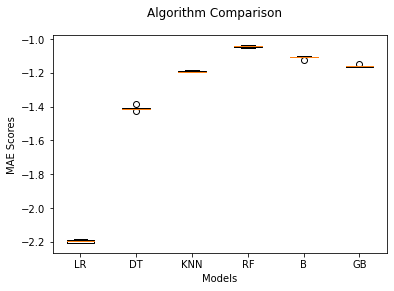

In [57]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(mae_reg_scores.values())
ax.set_xticklabels(mae_reg_scores.keys())

plt.plot()
plt.xlabel('Models')
plt.ylabel('MAE Scores')
plt.savefig('model_selection_dropped_length_perimtr_cv/South-Holland-Sample_MAE.png', dpi=600)


<Figure size 432x288 with 0 Axes>

In [63]:
if 'AB' in mae_reg_scores.keys():
    del mae_reg_scores['AB'] 
mae_reg_scores

{'LR': array([-2.20556828, -2.18994569, -2.19672848, -2.20663889, -2.18281595]),
 'DT': array([-1.40566136, -1.41142074, -1.38267443, -1.42484667, -1.41232023]),
 'KNN': array([-1.19742804, -1.1807711 , -1.1880864 , -1.19499008, -1.19378956]),
 'RF': array([-1.04831115, -1.03715511, -1.04105307, -1.05563088, -1.04432345]),
 'B': array([-1.10965381, -1.10401683, -1.1023629 , -1.12212378, -1.10414566]),
 'GB': array([-1.15984338, -1.14956769, -1.1669018 , -1.16276176, -1.16616974])}

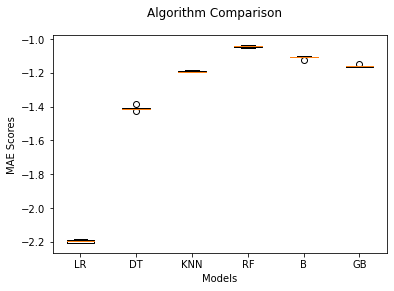

In [61]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(mae_reg_scores.values())
ax.set_xticklabels(mae_reg_scores.keys())

plt.plot()
plt.xlabel('Models')
plt.ylabel('MAE Scores')
plt.savefig('model_selection_dropped_length_perimtr_cv/South-Holland-Sample_MAE_Except-AB.png', dpi=600)



In [64]:
mse_reg_scores = {}

In [65]:
for name, regressor in regressors:
    cv = ShuffleSplit(n_splits=5, test_size=.3, random_state=42)
    mdl_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', regressor)])
    scores = cross_val_score(mdl_pipeline, X_train, y_train, cv=cv, scoring='neg_mean_squared_error', error_score='raise', n_jobs=-1)
    mse_reg_scores[name] = scores
    msg = "%s: avg: %f (std: %f, max: %f, min: %f)" % (name, scores.mean(), scores.std(), scores.max(), scores.min())
    print(msg)

LR: avg: -8.871507 (std: 0.409485, max: -8.473719, min: -9.427296)
DT: avg: -8.898112 (std: 0.497577, max: -8.356114, min: -9.714631)
KNN: avg: -5.049369 (std: 0.146694, max: -4.815735, min: -5.215162)
RF: avg: -4.273277 (std: 0.108769, max: -4.109295, min: -4.407108)
AB: avg: -27.787811 (std: 14.997299, max: -10.186093, min: -55.085067)
B: avg: -4.686037 (std: 0.141402, max: -4.494697, min: -4.834635)
GB: avg: -4.603839 (std: 0.165808, max: -4.439613, min: -4.820482)


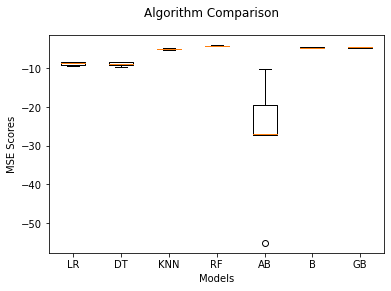

In [66]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(mse_reg_scores.values())
ax.set_xticklabels(mse_reg_scores.keys())

plt.plot()
plt.xlabel('Models')
plt.ylabel('MSE Scores')
plt.savefig('model_selection_dropped_length_perimtr_cv/South-Holland-Sample_MSE.png', dpi=600)
plt.show()

In [67]:
if 'AB' in mse_reg_scores.keys():
    del mse_reg_scores['AB'] 
mse_reg_scores

{'LR': array([-8.61948949, -8.47371889, -9.30795156, -8.52907923, -9.42729562]),
 'DT': array([-8.43072179, -9.71463093, -8.35611438, -9.13666499, -8.85242755]),
 'KNN': array([-5.02243767, -4.81573454, -5.21516155, -4.99598976, -5.19752025]),
 'RF': array([-4.2353807 , -4.10929535, -4.40710765, -4.23449527, -4.38010558]),
 'B': array([-4.53862501, -4.49469668, -4.80823377, -4.83463517, -4.75399209]),
 'GB': array([-4.50072393, -4.43961334, -4.8204822 , -4.46850434, -4.78987246])}

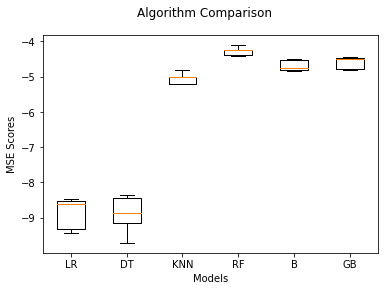

In [68]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(mse_reg_scores.values())
ax.set_xticklabels(mse_reg_scores.keys())

plt.plot()
plt.xlabel('Models')
plt.ylabel('MSE Scores')
plt.savefig('model_selection_dropped_length_perimtr_cv/South-Holland-Sample_MSE_Except-AB.png', dpi=600)
plt.show()

In [69]:
r2_reg_scores = {}

In [70]:
for name, regressor in regressors:
    cv = ShuffleSplit(n_splits=5, test_size=.3, random_state=42)
    mdl_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', regressor)])
    scores = cross_val_score(mdl_pipeline, X_train, y_train, cv=cv, scoring='r2', error_score='raise', n_jobs=-1)
    r2_reg_scores[name] = scores
    msg = "%s: avg: %f (std: %f, max: %f, min: %f)" % (name, scores.mean(), scores.std(), scores.max(), scores.min())
    print(msg)

LR: avg: 0.374344 (std: 0.024540, max: 0.400881, min: 0.343675)
DT: avg: 0.375799 (std: 0.033418, max: 0.409033, min: 0.315290)
KNN: avg: 0.643838 (std: 0.008709, max: 0.658305, min: 0.634355)
RF: avg: 0.699384 (std: 0.005107, max: 0.708355, min: 0.693979)
AB: avg: -0.866015 (std: 1.017316, max: 0.269766, min: -2.727325)
B: avg: 0.670334 (std: 0.004470, max: 0.677619, min: 0.664577)
GB: avg: 0.675444 (std: 0.009614, max: 0.686421, min: 0.662311)


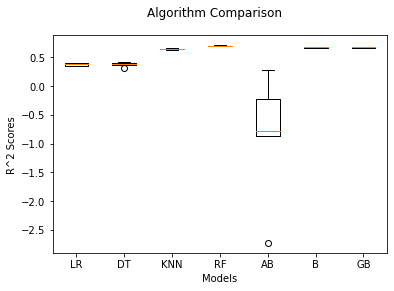

In [71]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(r2_reg_scores.values())
ax.set_xticklabels(r2_reg_scores.keys())

plt.plot()
plt.xlabel('Models')
plt.ylabel('R^2 Scores')
plt.savefig('model_selection_dropped_length_perimtr_cv/South-Holland-Sample_R2.png', dpi=600)
plt.show()

In [72]:
if 'AB' in r2_reg_scores.keys():
    del r2_reg_scores['AB']
r2_reg_scores

{'LR': array([0.38100228, 0.39875771, 0.34740164, 0.40088117, 0.34367501]),
 'DT': array([0.40903348, 0.31528964, 0.40320332, 0.36995417, 0.38151611]),
 'KNN': array([0.63932   , 0.65830548, 0.63435501, 0.64906041, 0.63815048]),
 'RF': array([0.6979779 , 0.70835532, 0.69397938, 0.70116528, 0.69544218]),
 'B': array([0.66697175, 0.67761876, 0.67184363, 0.66457665, 0.6706584 ]),
 'GB': array([0.67676051, 0.68500319, 0.66231128, 0.6864213 , 0.66672132])}

In [ ]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(r2_reg_scores.values())
ax.set_xticklabels(r2_reg_scores.keys())

plt.plot()
plt.xlabel('Models')
plt.ylabel('R^2 Scores')
plt.savefig('model_selection_dropped_length_perimtr_cv/South-Holland-Sample_R2_Except-AB.png', dpi=600)
plt.show()

In [88]:
cat_cols

['city', 'postcode']

In [89]:
num_cols

['area',
 'building_levels',
 'year',
 'count_vertices',
 'compactness',
 'complexity',
 'count_neighbor']

In [126]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean', add_indicator=True)),
    ('scaler', StandardScaler()),
    ('kbest', SelectKBest(f_regression, k='all'))])


In [127]:
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', add_indicator=True, fill_value="NA")),
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ('kbest', SelectKBest(f_regression, k='all'))])

In [128]:
preprocessor = ColumnTransformer(transformers=[
        ('num_transformer', num_transformer, num_cols),
        ('cat_transformer', cat_transformer, cat_cols)])

In [129]:
cv = ShuffleSplit(n_splits=5, test_size=.3, random_state=42)
gs_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', RandomForestRegressor(n_jobs=-1))])

In [ ]:
grid_params = {
    'preprocessor__num_transformer__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'preprocessor__num_transformer__kbest__k': ['all', 5, 3],
    'preprocessor__cat_transformer__kbest__k': ['all', 100, 50, 25],
    'regressor__max_depth': [3, 5, 10, 25, 30, 50],
    'regressor__n_estimators': [10, 100, 500, 1000],
    'regressor__max_features': ['auto', 'sqrt']
}

grid_search = GridSearchCV(gs_pipeline, grid_params, cv=cv, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

In [ ]:
best_params = grid_search.best_params_
best_params

In [ ]:
best_estimator = grid_search.best_estimator_
print(best_estimator)


In [ ]:
best_score = grid_search.best_score_
best_score